# Bayesian UQ-SINDy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

import pysindy as ps

In [2]:
# set seed for reproducibility
np.random.seed(987)

### Lotka-Volterra Predator-Prey Model

In this example, we generate the data using the Lotka-Volterra equations, which is a simplified model of Predator-Prey interactions. They specify a system of Ordinary Differential Equations (ODEs):
\begin{align}
\frac{dP}{dt} &= a P - b P Q\\
\frac{dQ}{dt} &= c P Q - d Q
\end{align}
where $P$ is the concentration of prey, $Q$ is the concentration of predators, $a$ is the birth rate of prey, $b$ is the death rate of prey, $c$ is the birth rate of predators and $d$ is the death rate of predators.

For more details, see e.g. Rockwood L. L. and Witt J. W. (2015). *Introduction to population ecology*. Wiley Blackwell, Chichester, West Sussex, UK, 2nd edition

In [3]:
# set up a class that defines the Lotka-Volterra equations
class PredatorPreyModel:
    def __init__(self, a=1.0, b=0.3, c=0.2, d=1.0):
        # internalise the model parameters.
        self.a = a
        self.b = b
        self.c = c
        self.d = d

    def dydx(self, t, y):
        # Lotka-Volterra Model model, see e.g. https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations.}
        return np.array([self.a*y[0] - self.b*y[0]*y[1], self.c*y[0]*y[1] - self.d*y[1]])

    def solve(self, **kwargs):
        # solve the system of ODEs.
        return solve_ivp(self.dydx, **kwargs)

In [4]:
# set some hyperparameters.
t_span = [0, 30]
y0 = np.array([10,5])
max_step = 0.1

# initialise the model and solve.
my_model = PredatorPreyModel()
sol = my_model.solve(t_span=t_span, y0=y0, max_step=max_step)

In [5]:
# the noise level.
noise = 0.1

# extract the timesteps and perturb the solution with noise.
t = sol.t
P = sol.y[0,:] + np.random.normal(scale=noise, size=sol.t.size)
Q = sol.y[1,:] + np.random.normal(scale=noise, size=sol.t.size)

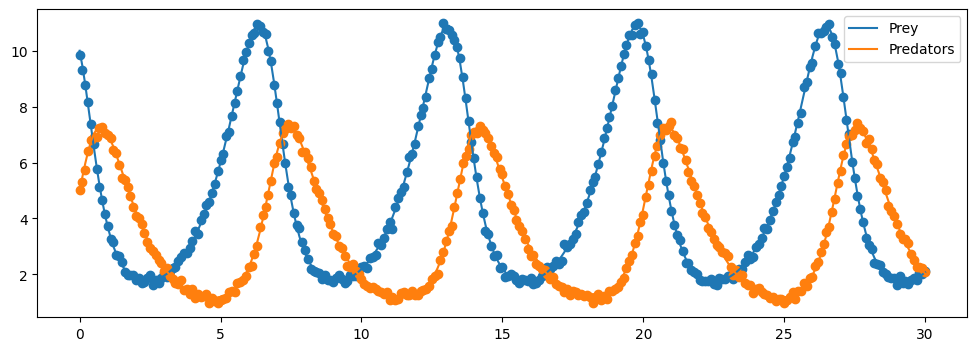

In [6]:
# plot the solution.
plt.figure(figsize=(12,4))
plt.plot(sol.t, sol.y[0,:], label = "Prey")
plt.scatter(t, P)
plt.plot(sol.t, sol.y[1,:], label="Predators")
plt.scatter(t, Q)
plt.legend()
plt.show()

### Bayesian UQ-SINDy

Here we recover the governing equations using UQ-SINDy. For more details on the theory of the method, see Hirsh, S. M., Barajas-Solano, D. A., & Kutz, J. N. (2021). *Sparsifying Priors for Bayesian Uncertainty Quantification in Model Discovery* (arXiv:2107.02107). arXiv. http://arxiv.org/abs/2107.02107

The underlying code used to find the posterior distribution of model parameters is `numpyro.infer.MCMC` using the `numpyro.infer.NUTS` kernel. Note that all keyword arguments passed to `pysindy.optimizers.SBR` are sent forward to the [MCMC sampler](https://num.pyro.ai/en/stable/mcmc.html).

In [7]:
# set sampler hyperparameters
sampling_seed = 123

if __name__ == "testing":
    num_warmup = 10
    num_samples = 100
    num_chains = 1
else:
    num_warmup = 500
    num_samples = 2000
    num_chains = 2

In [8]:
# initialise the Sparse bayesian Regression optimizer.
optimizer = ps.optimizers.SBR(seed=sampling_seed, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

# use the standard polynomial features.
feature_library = ps.feature_library.polynomial_library.PolynomialLibrary(include_interaction=True)

# initialise SINDy and fit to the data.
sindy = ps.SINDy(optimizer, feature_library, feature_names=['P', 'Q'])
sindy.fit(np.c_[P, Q], t=t)

sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 2170.87it/s, 63 steps of size 7.15e-02. acc. prob=0.81]


SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['P', 'Q'],
      optimizer=SBR())

In [9]:
# set up a new differential equation that uses the Bayesian SINDy predictions.
def surrogate_dydt(t, y):
    _y = y[np.newaxis,:]
    return sindy.predict(x=_y)

# solve using the Bayesian SINDy equations.
surrogate_sol = solve_ivp(surrogate_dydt, t_span=t_span, y0=y0, max_step=max_step)

In [10]:
print(type(__name__))

<class 'str'>


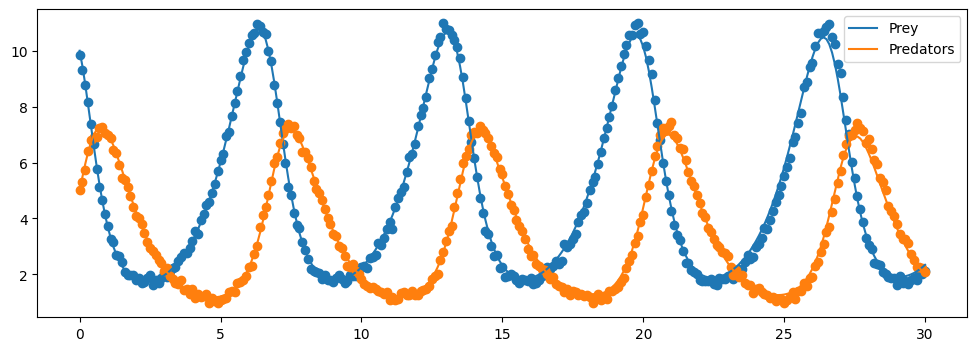

In [11]:
# plot the surrogate solution.
plt.figure(figsize=(12,4))

plt.plot(surrogate_sol.t, surrogate_sol.y[0,:], label = "Prey")
plt.scatter(t, P)

plt.plot(surrogate_sol.t, surrogate_sol.y[1,:], label="Predators")
plt.scatter(t, Q)

plt.legend()
plt.show()

### Get MCMC diagnostics

We can inspect the posterior samples in more detail using `arviz`. Note that this is not included as a dependency of `pysindy` and must be installed separately.

In [12]:
# import arviz.
import arviz as az

In [13]:
# convert the numpyro samples to an arviz.InferenceData object.
samples = az.from_numpyro(sindy.optimizer.mcmc)

# have a look at the summray.
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.019,0.106,-0.178,0.251,0.004,0.003,825.0,755.0,1.0
"beta[0, 1]",0.986,0.048,0.889,1.072,0.002,0.001,784.0,1045.0,1.0
"beta[0, 2]",0.005,0.041,-0.076,0.083,0.001,0.001,1208.0,998.0,1.0
"beta[0, 3]",-0.001,0.005,-0.010,0.009,0.000,0.000,868.0,223.0,1.0
"beta[0, 4]",-0.296,0.008,-0.310,-0.280,0.000,0.000,2142.0,2051.0,1.0
"beta[0, 5]",-0.002,0.007,-0.016,0.012,0.000,0.000,1615.0,1524.0,1.0
"beta[1, 0]",-0.003,0.127,-0.294,0.185,0.006,0.005,740.0,623.0,1.0
"beta[1, 1]",0.005,0.035,-0.060,0.072,0.001,0.001,806.0,677.0,1.0
"beta[1, 2]",-1.016,0.070,-1.156,-0.897,0.002,0.002,918.0,906.0,1.0
"beta[1, 3]",0.000,0.004,-0.007,0.008,0.000,0.000,1147.0,1042.0,1.0


[]

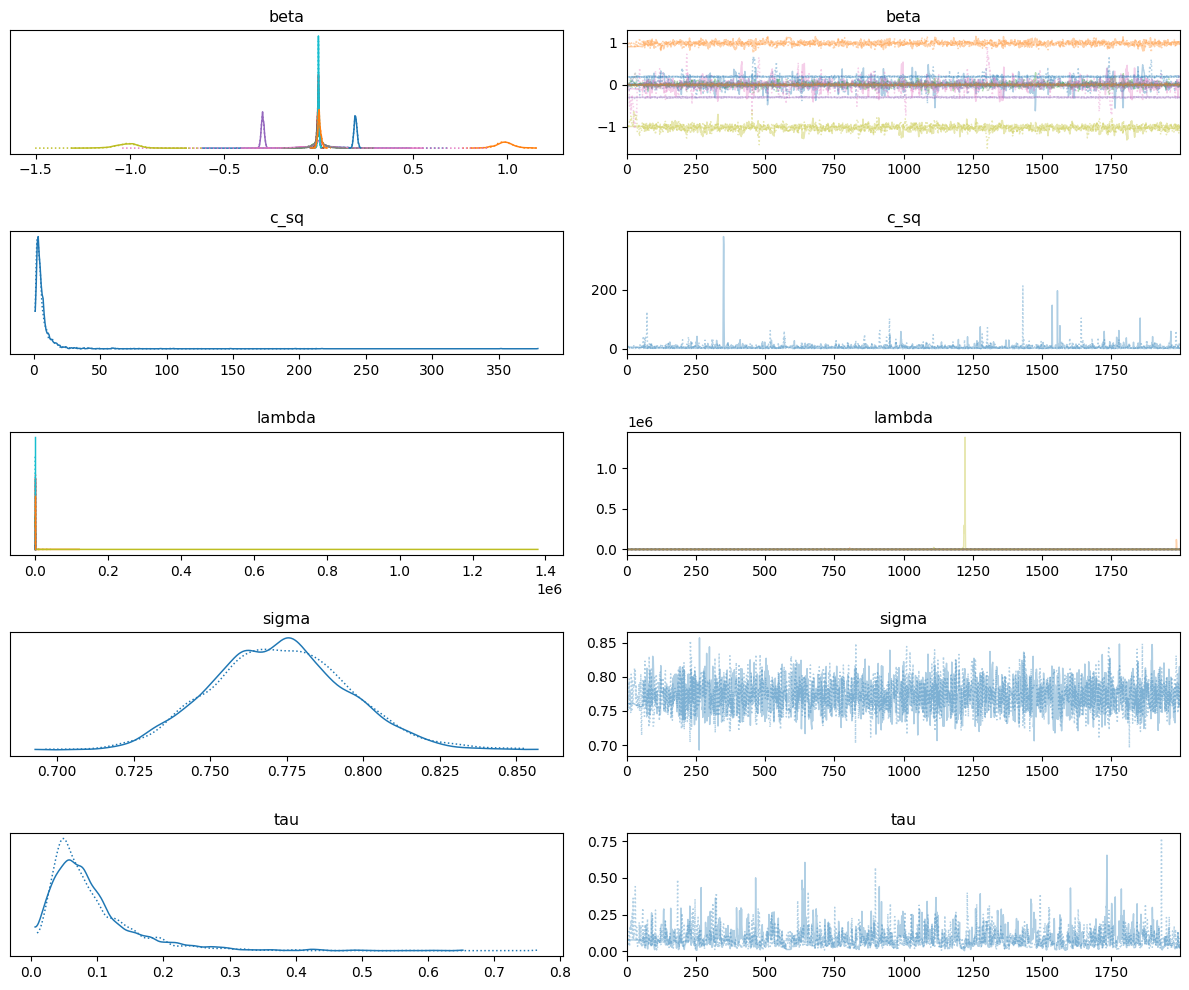

In [14]:
# plot the traces.
az.plot_trace(samples, divergences=False)
plt.tight_layout()
plt.plot()